Purpose of this notebook: 
* reads and summarizes the outputs from projections and smoothing
* creates LaTeX table for the paper 


In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [9]:
%autoreload 2
%matplotlib inline 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams['figure.figsize'] = (10, 8)

In [10]:
from __future__ import print_function
import pandas as pd
import h5py
import sys
sys.path.append("../")
import extract_catalog as ec
import get_DM_centroids as getDM
# import seaborn as sns
import compute_distance as compDist
import plot_cred_int as plotCI
import get_KDE

In [7]:
# sns.set_style('white')

In [8]:
data_path = "../../data/test_results/"

# read in files 

In [13]:
clstNo = 43
date_stamp = '06_17_16'

DM_fhats = \
    h5py.File(data_path +
              "DM_fhat_clst{0}_{1}.h5".format(
            clstNo, date_stamp), 'r')
star_fhats = \
    h5py.File(data_path +
              "stars_fhat_clst{0}_{1}.h5".format(
            clstNo, date_stamp), 'r')
main_FOF_h5 = h5py.File(
        "../../data/" +
        "Illustris-1_fof_subhalo_myCompleteHaloCatalog_00135" +
        ".hdf5", "r")

# figure out how many projections we did 

In [14]:
clstNo = [int(no) for no in star_fhats.keys()]

In [19]:
star_paths = compDist.retrieve_cluster_path(star_fhats)

In [22]:
len(star_paths)

16512

the list of `DM_paths` are 

The projections do not mean a thing except for debugging purposes, 
only the `clstNo` is a valid identifier 

In [23]:
split_path = star_paths[0].split('/')

In [24]:
fixed_path = '/'.join(split_path[1:4])

In [16]:
path = '0' + '/' + fixed_path

In [26]:
projections = star_fhats[str(clstNo[0]) + '/' + fixed_path].keys()

## columns in my uber dataframe (projection independent part)
| ClstNo | $m_{200c}$ | richness | relaxedness0| relaxedness1 |  


## projection dependent part 
| ClstNo | kernel_width | $\Delta s_{BCG}$ | $\Delta s_{KDE}$ | $\zeta$ | $\Delta s_{SA}$ | $\Delta s_{C}$ |  projection | total_peaks_dens | 

ClstNo is retained to match and join the two sets of `df`

# gather the projection dependent part of the `uber_df`

In [30]:
DM_fhats[star_paths[0] + '/25.0/'].keys()

[u'peaks_dens', u'peaks_xcoords', u'peaks_ycoords']

In [160]:
df_list = []
for star_path in star_paths: 
    clstNo = [int(star_path.split('/')[0])]
    star_fhat = star_fhats[star_path]
    for bin_width in ['/0.0/', '/25.0/']:
        DM_fhat = DM_fhats[star_path + bin_width]
    
        # temporarily put results in matched_stat first
        matched_stat = \
            compDist.compute_distance_between_DM_and_gal_peaks(
                star_fhat, DM_fhat, assign_rand_sign=False
            )        
            
        # compute all other offsets before putting them somewhere 
        # for computing my uber_df
        dist_dict = compDist.compute_distance_for_other_peaks(
            matched_stat, star_fhat, summary_stat_keys=summary_stat_keys
        )
        peak_no = len(matched_stat['dist'])
        if peak_no > 1:
            df = pd.DataFrame(dist_dict, 
                              index=[clstNo[0] for i in range(peak_no)])
            df['peak_id'] = range(peak_no)
            df['KDE' ] = matched_stat['dist']
            
        else:
            df = pd.DataFrame(dist_dict, index=clstNo)
            df['peak_id'] = 0.
            df['KDE'] = matched_stat['dist'][:1]
            
        df['total_peaks_dens'] = np.sum(star_fhat['peaks_dens'])
        df['bin_width'] = float(bin_width[1:-1])    
        df_list.append(df)


In [161]:
uber_df_proj = pd.concat(df_list)

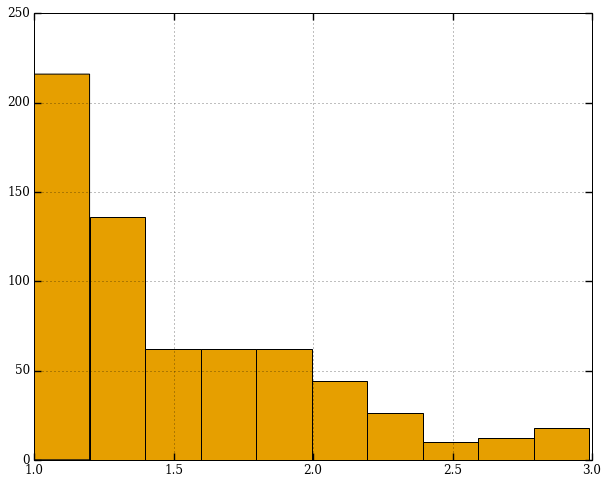

In [163]:
uber_df_proj.total_peaks_dens.hist()

# make plots

In [34]:
from pandas.tools.plotting import scatter_matrix

In [35]:
dom_peak_gpby = uber_df_proj.groupby(['peak_id', 'bin_width'])

In [36]:
dom_peak_df = dom_peak_gpby.get_group((0, 0.0))
dom_peak_df_25 = dom_peak_gpby.get_group((0, 25.0))

# assign dist to be either positive or negative randomly

In [41]:
for stat in ['BCG', u'centroid', u'shrink_cent', u'KDE']:
    dom_peak_df.loc[:, (stat)] = dom_peak_df.loc[:, (stat)].apply(
        lambda x: x * compDist.assign_sign_for_dist())

```Python
stat = "KDE"
dom_peak_df_25.loc[:, (stat)] = dom_peak_df_25.loc[:, (stat)].apply(
        lambda x: x * compDist.assign_sign_for_dist())
```

# make CI plots 

In [139]:
sum_stat_df_list = []
abs_sum_stat_df_list = [] 

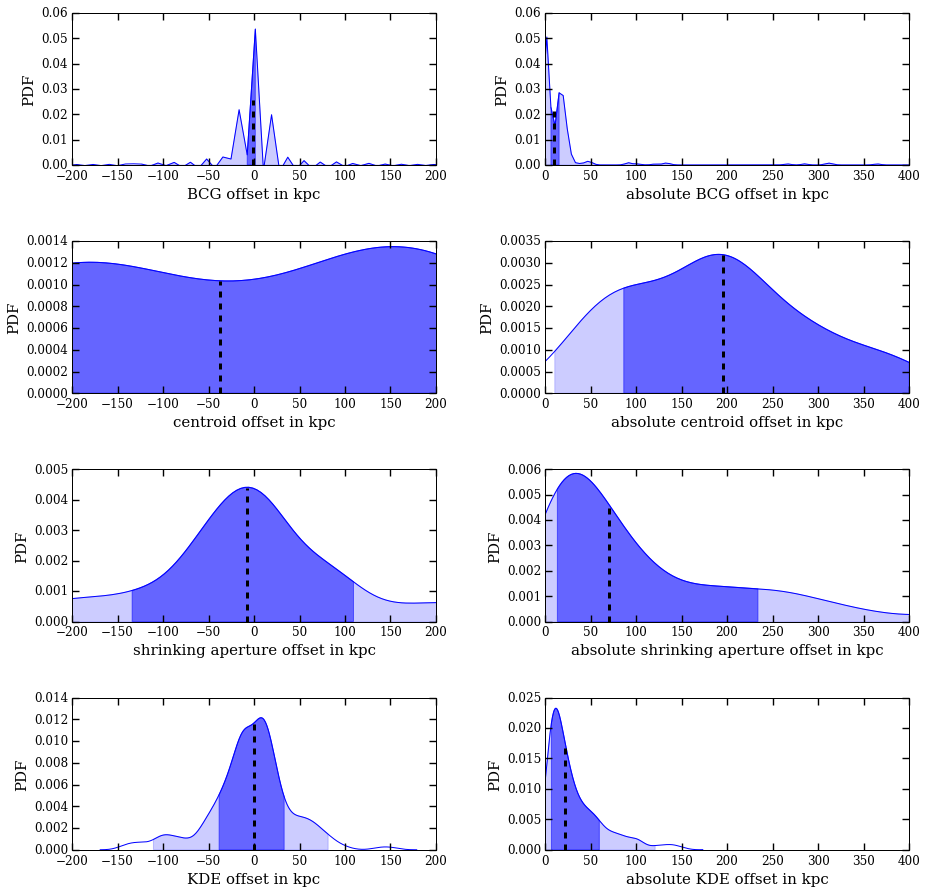

In [164]:
plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(
    4, 2
)
gs.update(hspace=0.5, wspace=0.3)
gs.set_width_ratios([1., 1.])
# gs.set_height_ratios([1., 1.])

ax_lists = [[plt.subplot(gs[row, col]) for col in range(2)]
            for row in range(4)] 

offset_labels = ['BCG', 'centroid', 'shrinking aperture', 'KDE']
title_on = False
for i, stat in enumerate(['BCG', u'centroid', u'shrink_cent', u'KDE']):
    ax1 = ax_lists[i][0]
    sum_stat1 = plotCI.CI_loc_plot(np.array(dom_peak_df[stat]), ax=ax1)
    ax1.set_xlim(-200, 200)
    
    ax2 = ax_lists[i][1]
    sum_stat2 = plotCI.CI_loc_plot(np.abs(dom_peak_df[stat]), ax=ax2)
    ax2.set_xlim(0, 400)
  
    ax1.set_ylabel('PDF')
    ax1.set_xlabel(offset_labels[i] + ' offset in kpc')
    if title_on:
        ax1.set_title(stat + 
                 " loc={0:.0f} $\pm$ {1:.0f}, {2:.0f}, {3:.0f}, {4:.0f}".format(
                 sum_stat1['loc'], sum_stat1['low68'], sum_stat1['up68'], 
                 sum_stat1['low95'], sum_stat1['up95'])
                )
    sum_stat_df_list.append(pd.DataFrame(sum_stat1, index=[stat]))
    
    ax2.set_ylabel('PDF')
    ax2.set_xlabel('absolute ' + offset_labels[i] + ' offset in kpc')
    if title_on:
        ax2.set_title(stat + 
                 " loc={0:.0f} $\pm$ {1:.0f}, {2:.0f}, {3:.0f}, {4:.0f}".format(
                 sum_stat2['loc'], sum_stat2['low68'], sum_stat2['up68'], 
                 sum_stat2['low95'], sum_stat2['up95'])
            )
    abs_sum_stat_df_list.append(pd.DataFrame(sum_stat2, index=[stat]))
    
plt.savefig('../../paper/figures/finalized/Fig5_offset_distribution.png',
            bbox_inches='tight')

In [141]:
sum_stat_df = pd.concat(sum_stat_df_list)
abs_sum_stat_df = pd.concat(abs_sum_stat_df_list)

# comments 

for final results there will be several tables:
* 

In [151]:
sum_stat_df.to_hdf("../../data/test_sum_stat.h5", "df")

/Users/karenyng/Documents/illustris_analyses/code/IlEnv/lib/python2.7/site-packages/pandas/io/pytables.py:2558: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis1] [items->None]

  warnings.warn(ws, PerformanceWarning)


In [152]:
abs_sum_stat_df.to_hdf("../../data/test_sum_stat.h5", "abs_df")

In [150]:
sum_stat_df.ix['BCG', 'loc']

-0.92131372826162639

# call the python wrapper to R function 

see if the density estimates differ a lot between the one made by "Silverman's" rule and 
the cross validation 

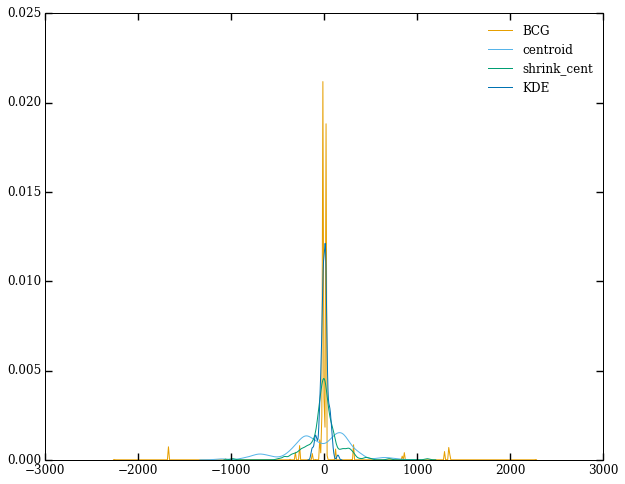

In [66]:
for stat in ['BCG', u'centroid', u'shrink_cent', u'KDE']:
    
    fhat = get_KDE.do_1D_KDE(np.array(dom_peak_df[stat]), 
                             convert_to_py_format=True)
    plt.plot(fhat['eval_points'], fhat['estimate'], label=stat)
   

plt.legend()

# gather the projection independent part of our uber dataframe

In [36]:
uber_df = compDist.construct_uber_result_df(
    star_fhats, DM_fhats, main_FOF_h5
)

In [37]:
uber_df

,clstNo,M200C,richness
0,48,1168.006836,53
1,51,1878.831665,56
2,58,1416.312622,58
